# FullClass-TrainCNN(InceptionV3)_NoFreezModel_No-ClassImbalance

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

## Training Set DIR

In [2]:
train_dataset_path='D:/DatasetMedicalWasteCropped/'

In [3]:
#train_dataset_path='D:/DatasetMedicalWasteCroppedBalanced/'

## Testing Set DIR

In [4]:
test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

In [5]:
img_height=299
img_width=299
batch_size=64

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 3095 files for training.


In [7]:
class_names = train_ds.class_names
class_number = len(class_names)
print(class_names)
print(f'number of class = {class_number}')

['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']
number of class = 41


In [8]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dataset_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3868 files belonging to 41 classes.
Using 773 files for validation.


In [9]:
test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1794 files belonging to 41 classes.


In [10]:
test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3140 files belonging to 41 classes.


In [11]:
test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2206 files belonging to 41 classes.


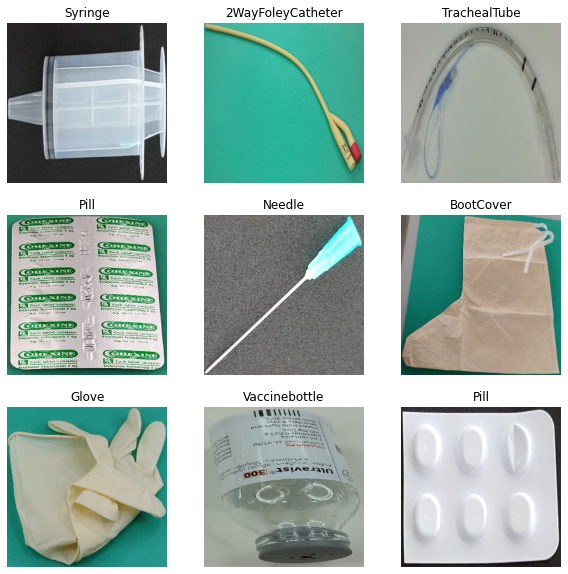

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

In [14]:
normalization_layer = layers.Rescaling(1./255)

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
train_ds = prepare(train_ds, shuffle=True, augment=False)
val_ds = prepare(val_ds)
test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

In [16]:
# Test -> Fetching Mini Batch
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 299, 299, 3)
(64,)


In [17]:
'''
vgg16_model = keras.applications.vgg16.VGG16()
model = Sequential()

for layer in vgg16_model.layers[:-1]: # this is where I changed your code
    model.add(layer)    

# Freeze the layers 
for layer in model.layers:
    layer.trainable = False

# Add 'softmax' instead of earlier 'prediction' layer.
model.add(Dense(2, activation='softmax'))
'''
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
import numpy as np
from tensorflow.keras.layers import Dense, Input, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

inceptionv3_model = keras.applications.InceptionV3(input_shape=(img_height,img_width,3),include_top=True,weights="imagenet",classifier_activation="softmax")

inceptionv3_model_nooutput = inceptionv3_model.layers[-2].output
custom_inceptionv3_model = Model(inputs = inceptionv3_model.input, outputs = inceptionv3_model_nooutput)


## Freez Extractor+

In [18]:
custom_inceptionv3_model.trainable = False
for layer in custom_inceptionv3_model.layers:
    layer.trainable = False
## Freez
#custom_inceptionv3_model.layers[-1].trainable = True
#custom_inceptionv3_model.layers[-2].trainable = True
#custom_inceptionv3_model.layers[-3].trainable = True
print(custom_inceptionv3_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [19]:
model = tf.keras.Sequential()
# Feature Extractor
model.add(custom_inceptionv3_model)
# Classifier
model.add(tf.keras.layers.Dense(len(class_names), activation='softmax', trainable=True))
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 41)                84009     
Total params: 21,886,793
Trainable params: 84,009
Non-trainable params: 21,802,784
_________________________________________________________________


# Fitting

In [1]:
path_to_model = 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/'

In [22]:
EPOCHS = 4000
save_model_interval = 40
checkpoint_filepath = path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch{epoch:04d}-val_acc{val_accuracy:.2f}.pb'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_freq='epoch',
    period=save_model_interval,
    save_best_only=False)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                  patience=5, min_lr=0.00001,cooldown=1, verbose=1)
# Model weights are saved at the end of every epoch, if it's the best seen
# so far.
history = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS, callbacks=[model_checkpoint_callback,reduce_lr])

Epoch 1/4000
49/49 [==============================] - 43s 331ms/step - loss: 1.8577 - accuracy: 0.5257 - val_loss: 0.9397 - val_accuracy: 0.7827
Epoch 2/4000
49/49 [==============================] - 9s 185ms/step - loss: 0.6622 - accuracy: 0.8465 - val_loss: 0.5592 - val_accuracy: 0.8745
Epoch 3/4000
49/49 [==============================] - 9s 189ms/step - loss: 0.4049 - accuracy: 0.9205 - val_loss: 0.4184 - val_accuracy: 0.9146
Epoch 4/4000
49/49 [==============================] - 9s 190ms/step - loss: 0.2884 - accuracy: 0.9477 - val_loss: 0.3426 - val_accuracy: 0.9263
Epoch 5/4000
49/49 [==============================] - 9s 193ms/step - loss: 0.2204 - accuracy: 0.9661 - val_loss: 0.2948 - val_accuracy: 0.9327
Epoch 6/4000
49/49 [==============================] - 9s 190ms/step - loss: 0.1758 - accuracy: 0.9742 - val_loss: 0.2617 - val_accuracy: 0.9431
Epoch 7/4000
49/49 [==============================] - 9s 190ms/step - loss: 0.1446 - accuracy: 0.9842 - val_loss: 0.2374 - val_accuracy

Text(0.5, 1.0, 'Training and Validation Accuracy')

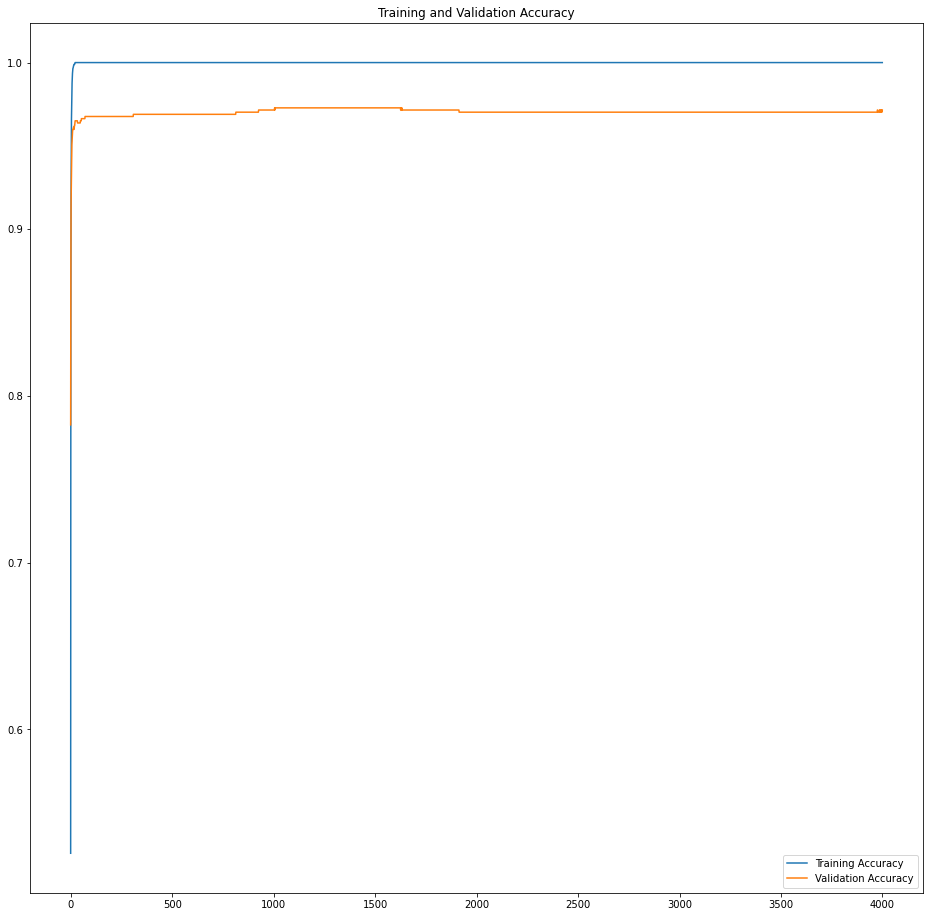

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 16))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


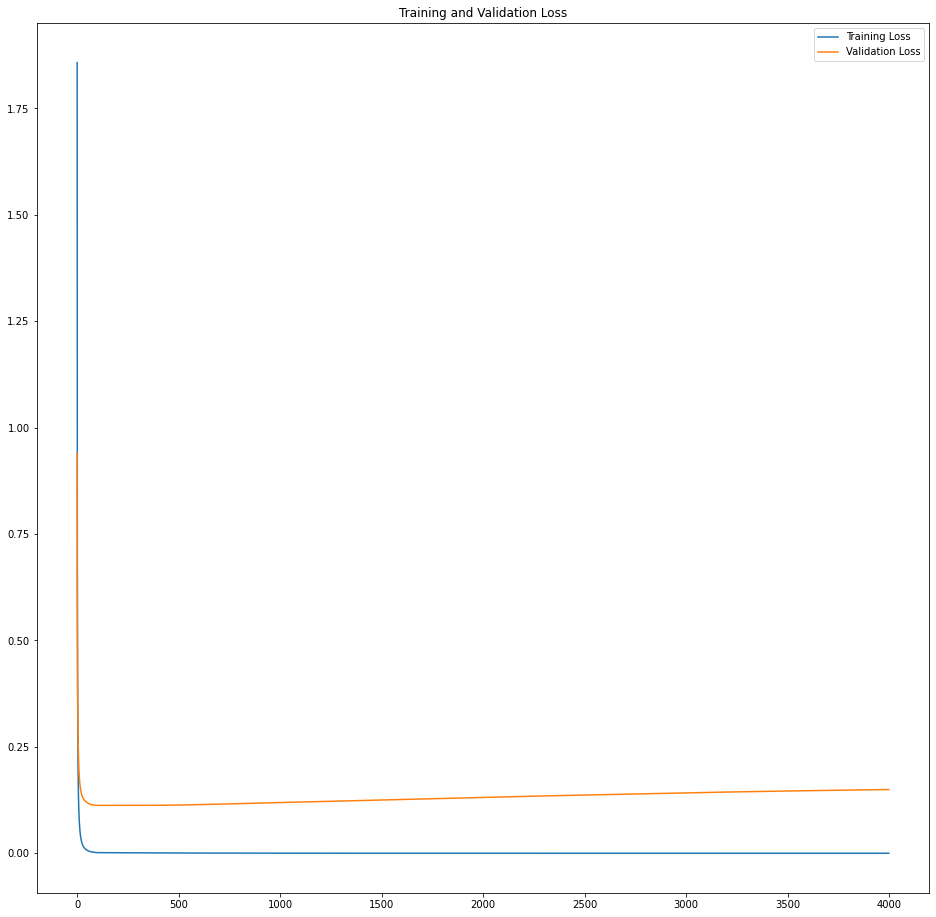

In [24]:
#plt.subplot(1, 2, 2)
plt.figure(figsize=(16, 16))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [25]:
#indoor testset
test_indoor_ds_results = model.evaluate(test_indoor_ds)
print("test_indoor_ds_results:test loss, test acc:", test_indoor_ds_results)

29/29 [==============================] - 14s 349ms/step - loss: 0.7666 - accuracy: 0.8512
test_indoor_ds_results:test loss, test acc: [0.7665674090385437, 0.851170539855957]


In [26]:
#outdoor testset
test_outdoor_ds_results = model.evaluate(test_outdoor_ds)
print("test_outdoor_ds_results:test loss, test acc:", test_outdoor_ds_results)

50/50 [==============================] - 26s 433ms/step - loss: 2.0722 - accuracy: 0.7376
test_outdoor_ds_results:test loss, test acc: [2.072248697280884, 0.7375796437263489]


In [27]:
#belt testset
test_belt_ds_results = model.evaluate(test_belt_ds)
print("test_belt_ds_results:test loss, test acc:", test_belt_ds_results)

35/35 [==============================] - 8s 198ms/step - loss: 2.2744 - accuracy: 0.6872
test_belt_ds_results:test loss, test acc: [2.2743682861328125, 0.6872166991233826]


In [28]:
# Read path of trained model
import os, os.path
trained_path = path_to_model
models_paths = []
for name_folder in os.listdir(trained_path):
    if os.path.isdir(os.path.join(trained_path, name_folder)):
        models_paths.append(os.path.join(trained_path, name_folder))
models_paths

['D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0040-val_acc0.96.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0080-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0120-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0160-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-VerySlowLR/OurOutputLayer-NoClassImbalanced-NoAug-epoch0200-val_acc0.97.pb',
 'D:/ModelMedicalWasteCheckpoint/Incepv3_FreezExtractorOurOutputLayer(LongEP)-NoClassImbalanced-NoAug-Ver

# Testing in testset

In [29]:
test_indoor_acc = []
test_outdoor_acc = []
test_belt_acc = []
test_indoor_loss = []
test_outdoor_loss = []
test_belt_loss = []

for lm_idx,plmodel in enumerate(models_paths):
    loaded_model=tf.keras.models.load_model(plmodel)
    ## -> keep loss / acc in each epoch
    #indoor
    test_indoor_results = loaded_model.evaluate(test_indoor_ds)
    test_indoor_loss.append(test_indoor_results[0]) # append loss
    test_indoor_acc.append(test_indoor_results[1]) # append acc
    #outdoor
    test_outdoor_results = loaded_model.evaluate(test_outdoor_ds)
    test_outdoor_loss.append(test_outdoor_results[0]) # append loss
    test_outdoor_acc.append(test_outdoor_results[1]) # append acc
    #belt
    test_belt_results = loaded_model.evaluate(test_belt_ds)
    test_belt_loss.append(test_belt_results[0]) # append loss
    test_belt_acc.append(test_belt_results[1]) # append acc
    # printout
    lm_idx_show = (lm_idx+1) * save_model_interval
    print(f"Epoch{lm_idx_show:03d} \n test_indoor_acc={test_indoor_acc[lm_idx]} \n test_outdoor_acc={test_outdoor_acc[lm_idx]} \n test_belt_acc={test_belt_acc[lm_idx]}")

35/35 [==============================] - 5s 141ms/step - loss: 1.3374 - accuracy: 0.6655
Epoch040 
 test_indoor_acc=0.8338907361030579 
 test_outdoor_acc=0.7385350465774536 
 test_belt_acc=0.6654578447341919
35/35 [==============================] - 5s 141ms/step - loss: 1.4442 - accuracy: 0.6709
Epoch080 
 test_indoor_acc=0.8405796885490417 
 test_outdoor_acc=0.740764319896698 
 test_belt_acc=0.6708975434303284
35/35 [==============================] - 5s 142ms/step - loss: 1.4898 - accuracy: 0.6759
Epoch120 
 test_indoor_acc=0.8450390100479126 
 test_outdoor_acc=0.740764319896698 
 test_belt_acc=0.675883948802948
35/35 [==============================] - 5s 142ms/step - loss: 1.4919 - accuracy: 0.6754
Epoch160 
 test_indoor_acc=0.8444815874099731 
 test_outdoor_acc=0.740764319896698 
 test_belt_acc=0.6754306554794312
35/35 [==============================] - 5s 139ms/step - loss: 1.4978 - accuracy: 0.6759
Epoch200 
 test_indoor_acc=0.8450390100479126 
 test_outdoor_acc=0.7404458522796631

range(40, 4040, 40)


Text(0.5, 1.0, 'Testing(EvaluationModel) Accuracy')

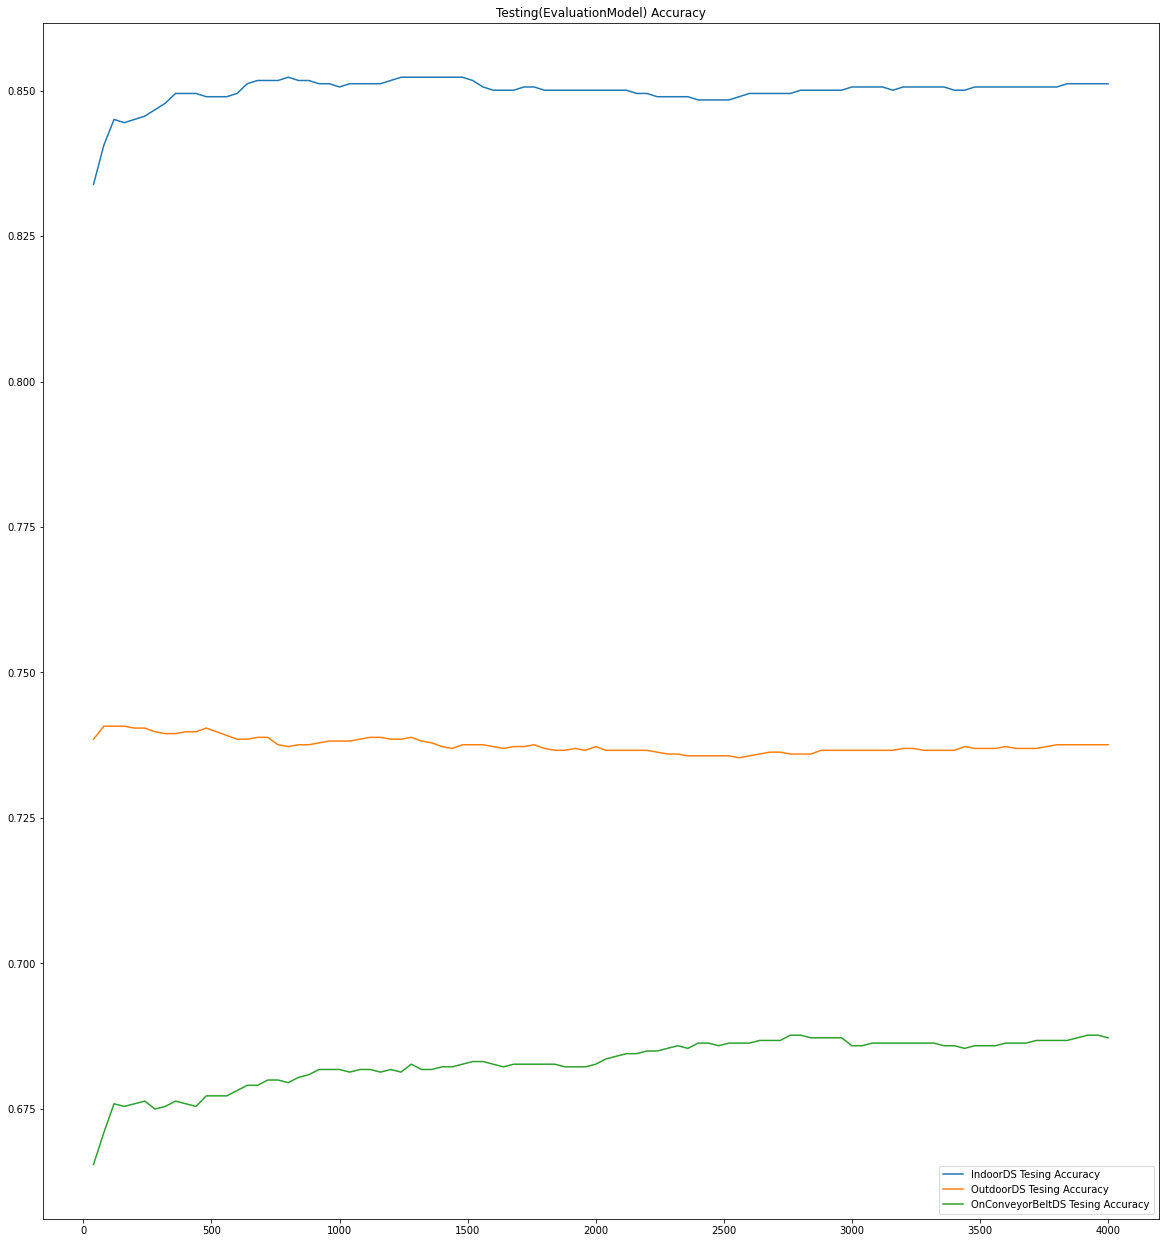

In [30]:
# loss / acc in each epoch graph ploting
#EPOCHS = 400
import matplotlib.pyplot as plt
epochs_range = range(save_model_interval,EPOCHS+save_model_interval,save_model_interval)
print(epochs_range)
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 1)
plt.plot(epochs_range, test_indoor_acc, label='IndoorDS Tesing Accuracy')
plt.plot(epochs_range, test_outdoor_acc, label='OutdoorDS Tesing Accuracy')
plt.plot(epochs_range, test_belt_acc, label='OnConveyorBeltDS Tesing Accuracy')
plt.legend(loc='lower right')
plt.title('Testing(EvaluationModel) Accuracy')

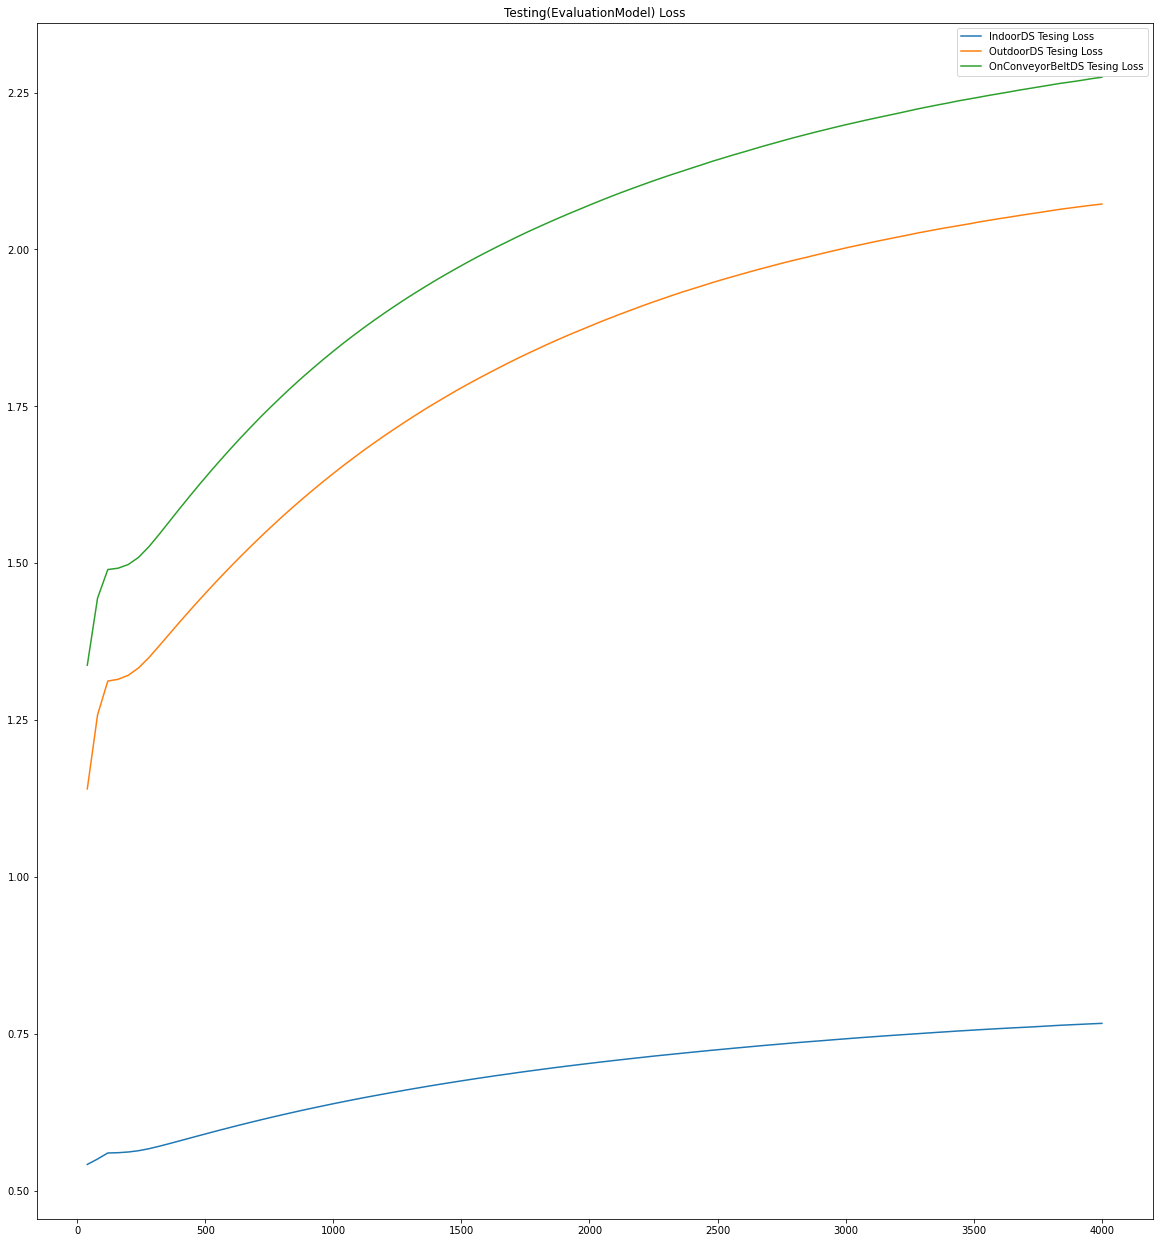

In [31]:
plt.figure(figsize=(20, 22))
#plt.subplot(1, 2, 2)
plt.plot(epochs_range, test_indoor_loss, label='IndoorDS Tesing Loss')
plt.plot(epochs_range, test_outdoor_loss, label='OutdoorDS Tesing Loss')
plt.plot(epochs_range, test_belt_loss, label='OnConveyorBeltDS Tesing Loss')
plt.legend(loc='upper right')
plt.title('Testing(EvaluationModel) Loss')
plt.show()

In [32]:
test_indoor_acc

[0.8338907361030579,
 0.8405796885490417,
 0.8450390100479126,
 0.8444815874099731,
 0.8450390100479126,
 0.845596432685852,
 0.846711277961731,
 0.8478260636329651,
 0.8494983315467834,
 0.8494983315467834,
 0.8494983315467834,
 0.848940908908844,
 0.848940908908844,
 0.848940908908844,
 0.8494983315467834,
 0.851170539855957,
 0.8517279624938965,
 0.8517279624938965,
 0.8517279624938965,
 0.8522853851318359,
 0.8517279624938965,
 0.8517279624938965,
 0.851170539855957,
 0.851170539855957,
 0.8506131768226624,
 0.851170539855957,
 0.851170539855957,
 0.851170539855957,
 0.851170539855957,
 0.8517279624938965,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8522853851318359,
 0.8517279624938965,
 0.8506131768226624,
 0.8500557541847229,
 0.8500557541847229,
 0.8500557541847229,
 0.8506131768226624,
 0.8506131768226624,
 0.8500557541847229,
 0.8500557541847229,
 0.8500557541847229,
 0.8500557541847229,
 0.8

In [33]:
test_outdoor_acc

[0.7385350465774536,
 0.740764319896698,
 0.740764319896698,
 0.740764319896698,
 0.7404458522796631,
 0.7404458522796631,
 0.7398089170455933,
 0.7394904494285583,
 0.7394904494285583,
 0.7398089170455933,
 0.7398089170455933,
 0.7404458522796631,
 0.7398089170455933,
 0.7391719818115234,
 0.7385350465774536,
 0.7385350465774536,
 0.7388535141944885,
 0.7388535141944885,
 0.7375796437263489,
 0.737261176109314,
 0.7375796437263489,
 0.7375796437263489,
 0.7378981113433838,
 0.7382165789604187,
 0.7382165789604187,
 0.7382165789604187,
 0.7385350465774536,
 0.7388535141944885,
 0.7388535141944885,
 0.7385350465774536,
 0.7385350465774536,
 0.7388535141944885,
 0.7382165789604187,
 0.7378981113433838,
 0.737261176109314,
 0.7369426488876343,
 0.7375796437263489,
 0.7375796437263489,
 0.7375796437263489,
 0.737261176109314,
 0.7369426488876343,
 0.737261176109314,
 0.737261176109314,
 0.7375796437263489,
 0.7369426488876343,
 0.7366241812705994,
 0.7366241812705994,
 0.7369426488876343,


In [34]:
test_belt_acc

[0.6654578447341919,
 0.6708975434303284,
 0.675883948802948,
 0.6754306554794312,
 0.675883948802948,
 0.6763372421264648,
 0.6749773621559143,
 0.6754306554794312,
 0.6763372421264648,
 0.675883948802948,
 0.6754306554794312,
 0.6772438883781433,
 0.6772438883781433,
 0.6772438883781433,
 0.678150475025177,
 0.6790571212768555,
 0.6790571212768555,
 0.6799637079238892,
 0.6799637079238892,
 0.6795104146003723,
 0.6804170608520508,
 0.6808703541755676,
 0.6817770004272461,
 0.6817770004272461,
 0.6817770004272461,
 0.6813236474990845,
 0.6817770004272461,
 0.6817770004272461,
 0.6813236474990845,
 0.6817770004272461,
 0.6813236474990845,
 0.6826835870742798,
 0.6817770004272461,
 0.6817770004272461,
 0.6822302937507629,
 0.6822302937507629,
 0.6826835870742798,
 0.6831368803977966,
 0.6831368803977966,
 0.6826835870742798,
 0.6822302937507629,
 0.6826835870742798,
 0.6826835870742798,
 0.6826835870742798,
 0.6826835870742798,
 0.6826835870742798,
 0.6822302937507629,
 0.68223029375076

In [35]:
test_indoor_loss

[0.5417606830596924,
 0.55036860704422,
 0.5600139498710632,
 0.5604642033576965,
 0.5615917444229126,
 0.5636482238769531,
 0.5667402148246765,
 0.5706713795661926,
 0.5749046802520752,
 0.5793047547340393,
 0.5837083458900452,
 0.588087260723114,
 0.5924181938171387,
 0.5967295169830322,
 0.6009271740913391,
 0.6050776243209839,
 0.609123945236206,
 0.6130925416946411,
 0.6169875860214233,
 0.6207736730575562,
 0.6244592070579529,
 0.6281195878982544,
 0.6316239833831787,
 0.6350831985473633,
 0.6384914517402649,
 0.6417744159698486,
 0.6450208425521851,
 0.6481687426567078,
 0.6512277126312256,
 0.6542131900787354,
 0.6571815609931946,
 0.6600792407989502,
 0.6629056334495544,
 0.6656903028488159,
 0.6684166193008423,
 0.6710413098335266,
 0.6736406087875366,
 0.6761903166770935,
 0.6786733865737915,
 0.6811173558235168,
 0.6835225224494934,
 0.6857689023017883,
 0.6881390810012817,
 0.6903497576713562,
 0.6925266981124878,
 0.6946803331375122,
 0.696826159954071,
 0.698836863040924

In [36]:
test_outdoor_loss

[1.1402649879455566,
 1.2581530809402466,
 1.3120684623718262,
 1.3148908615112305,
 1.3213330507278442,
 1.3330074548721313,
 1.3493142127990723,
 1.367884874343872,
 1.3869572877883911,
 1.4058618545532227,
 1.4244370460510254,
 1.4426194429397583,
 1.4604350328445435,
 1.4778034687042236,
 1.4948018789291382,
 1.5113621950149536,
 1.5275659561157227,
 1.5433462858200073,
 1.558698296546936,
 1.5737638473510742,
 1.5883736610412598,
 1.602543830871582,
 1.6163105964660645,
 1.6298154592514038,
 1.6428568363189697,
 1.6556953191757202,
 1.6680212020874023,
 1.6801435947418213,
 1.6917636394500732,
 1.7031590938568115,
 1.7141742706298828,
 1.7249521017074585,
 1.7354923486709595,
 1.745819330215454,
 1.7556413412094116,
 1.7653170824050903,
 1.7748488187789917,
 1.7840662002563477,
 1.7928671836853027,
 1.8014956712722778,
 1.809988260269165,
 1.818364143371582,
 1.8264528512954712,
 1.8343108892440796,
 1.841896653175354,
 1.849496841430664,
 1.8567216396331787,
 1.8638582229614258,


In [ ]:
test_belt_loss

[1.2229410409927368,
 1.2617417573928833,
 1.30482017993927,
 1.3389554023742676,
 1.3695478439331055,
 1.39886474609375,
 1.4268885850906372,
 1.4535846710205078,
 1.4793684482574463,
 1.4944313764572144,
 1.4974725246429443,
 1.4981461763381958,
 1.4987356662750244,
 1.4995266199111938,
 1.5002691745758057,
 1.5012158155441284,
 1.502519130706787,
 1.5038548707962036,
 1.5054938793182373,
 1.5074528455734253,
 1.5097259283065796,
 1.5123980045318604,
 1.5154889822006226,
 1.5187898874282837,
 1.5225003957748413,
 1.526523232460022,
 1.5307945013046265,
 1.5352972745895386,
 1.5399428606033325,
 1.5447291135787964,
 1.5496232509613037,
 1.554582953453064,
 1.5594857931137085,
 1.564516305923462,
 1.5695061683654785,
 1.5745269060134888,
 1.5795365571975708,
 1.5845668315887451,
 1.5895215272903442,
 1.5944559574127197,
 1.5994786024093628,
 1.604455828666687,
 1.6092876195907593,
 1.6141786575317383,
 1.6189481019973755,
 1.623894453048706,
 1.6287224292755127,
 1.6335630416870117,
 1

## Load Last Epoch and test in each class

In [57]:
# Del dataset memory and reload
# RAM
del train_ds
del val_ds
del test_indoor_ds
del test_outdoor_ds
del test_belt_ds
# VRAM
from numba import cuda
cuda.select_device(0)
cuda.close()

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
import numpy as np
from keras.applications.vgg16 import preprocess_input

last_epoch_model = tf.keras.models.load_model(path_to_model+'OurOutputLayer-NoClassImbalanced-NoAug-epoch4000-val_acc0.97.pb')

test_indoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/indoor'
test_outdoor_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/outdoor'
test_belt_dataset_path='D:/DatasetMedicalWasteTestLabeledCropped/belt'

img_height=299
img_width=299
batch_size=64

test_indoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_indoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_outdoor_ds = tf.keras.utils.image_dataset_from_directory(
  test_outdoor_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

test_belt_ds = tf.keras.utils.image_dataset_from_directory(
  test_belt_dataset_path,
  image_size=(img_height, img_width),
  batch_size=batch_size)

normalization_layer = layers.Rescaling(1./255)

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(height_factor=0.1),
  layers.RandomContrast(0.05),
])

#Apply the preprocessing layers to your dataset
AUTOTUNE = tf.data.AUTOTUNE
#train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

def prepare(ds, shuffle=False, augment=False):
  # Normalize by 255 all datasets.
  ds = ds.map(lambda x, y: (normalization_layer(x), y), num_parallel_calls=AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(2000)

  # Batch all datasets.
  #ds = ds.batch(batch_size)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.cache().prefetch(buffer_size=AUTOTUNE)

test_indoor_ds = prepare(test_indoor_ds)
test_outdoor_ds = prepare(test_outdoor_ds)
test_belt_ds = prepare(test_belt_ds)

class_names = ['1WayConnectorforFoley', '2WayConnectorforFoley', '2WayFoleyCatheter', '3WayConnectorforFoley', '3Waystopcock', 'AlcoholBottle', 'AlcoholPad', 'BootCover', 'CottonBall', 'CottonSwap', 'Dilator', 'DisposableInfusionSet', 'ExtensionTube', 'FaceShield', 'FrontLoadSyringe', 'GauzePad', 'Glove', 'GuideWire', 'LiquidBottle', 'Mask', 'NGTube', 'NasalCannula', 'Needle', 'OxygenMask', 'PPESuit', 'PharmaceuticalProduct', 'Pill', 'PillBottle', 'PrefilledHumidifier', 'PressureConnectingTube', 'ReusableHumidifier', 'SodiumChlorideBag', 'SterileHumidifierAdapter', 'SurgicalBlade', 'SurgicalCap', 'SurgicalSuit', 'Syringe', 'TrachealTube', 'UrineBag', 'Vaccinebottle', 'WingedInfusionSet']

x_test_indoor = np.concatenate([ x for x,y in test_indoor_ds],axis=0)
x_test_outdoor = np.concatenate([ x for x,y in test_outdoor_ds],axis=0)
x_test_belt = np.concatenate([ x for x,y in test_belt_ds],axis=0)
y_test_indoor = np.concatenate([ y for x,y in test_indoor_ds],axis=0)
y_test_outdoor = np.concatenate([ y for x,y in test_outdoor_ds],axis=0)
y_test_belt = np.concatenate([ y for x,y in test_belt_ds],axis=0)
print(f"train_indoor num x,y : {len(x_test_indoor)},{len(y_test_indoor)}")
print(f"train_outdoor num x,y : {len(x_test_outdoor)},{len(y_test_outdoor)}")
print(f"train_belt num x,y : {len(x_test_belt)},{len(y_test_belt)}")
x_all = np.concatenate([x_test_indoor,x_test_outdoor,x_test_belt],axis=0)
y_all = np.concatenate([y_test_indoor,y_test_outdoor,y_test_belt],axis=0)
print(f"all num x,y :{len(x_all)},{len(y_all)}")
# let's predict
y_all_predicted = last_epoch_model.predict(x_all,batch_size=128)

Found 1794 files belonging to 41 classes.
Found 3140 files belonging to 41 classes.
Found 2206 files belonging to 41 classes.
train_indoor num x,y : 1794,1794
train_outdoor num x,y : 3140,3140
train_belt num x,y : 2206,2206
all num x,y :7140,7140


In [5]:
y_all_predicted_max = np.array([],dtype=np.int)
# acc all
TP = 0
FP = 0
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP = TP + 1
    else :
        FP = FP + 1
    y_all_predicted_max=np.append(y_all_predicted_max,np.argmax(y_all_predicted[i]))
print(f'all={TP+FP}')
print(f'TP={TP}')
print(f'FP={FP}')
print(f'acc={TP/(TP+FP)}')

# acc eachclass
TP_eachclass = [0] * 41
FP_eachclass = [0] * 41
for i in range(len(y_all)):
    if(y_all[i]==np.argmax(y_all_predicted[i])):
        TP_eachclass[y_all[i]] = TP_eachclass[y_all[i]] + 1
    else :
        FP_eachclass[y_all[i]] = FP_eachclass[y_all[i]] + 1
#recheck
print(f'all check = {sum(TP_eachclass)+sum(FP_eachclass)}')

all=7140
TP=5359
FP=1781
acc=0.7505602240896359
all check = 7140


In [6]:
avg_acc_eachclass = []
for i in range(len(class_names)):
    print(f'{class_names[i]} acc = {TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100}%')
    avg_acc_eachclass.append(TP_eachclass[i]/(TP_eachclass[i]+FP_eachclass[i])*100)
all_avg_eachclass = sum(avg_acc_eachclass) / len(avg_acc_eachclass)
print(f'\n\n\nall_avg_eachclass = {all_avg_eachclass}%')


1WayConnectorforFoley acc = 71.55172413793103%
2WayConnectorforFoley acc = 90.47619047619048%
2WayFoleyCatheter acc = 75.3731343283582%
3WayConnectorforFoley acc = 94.01709401709401%
3Waystopcock acc = 99.09909909909909%
AlcoholBottle acc = 86.875%
AlcoholPad acc = 47.61904761904761%
BootCover acc = 66.26506024096386%
CottonBall acc = 75.44910179640718%
CottonSwap acc = 77.62237762237763%
Dilator acc = 71.7948717948718%
DisposableInfusionSet acc = 53.09734513274337%
ExtensionTube acc = 38.21138211382114%
FaceShield acc = 69.75308641975309%
FrontLoadSyringe acc = 54.86725663716814%
GauzePad acc = 60.79545454545454%
Glove acc = 74.70238095238095%
GuideWire acc = 33.035714285714285%
LiquidBottle acc = 62.97709923664122%
Mask acc = 93.76623376623377%
NGTube acc = 45.16129032258064%
NasalCannula acc = 69.02654867256636%
Needle acc = 81.78571428571428%
OxygenMask acc = 97.74436090225564%
PPESuit acc = 95.16129032258065%
PharmaceuticalProduct acc = 63.084112149532714%
Pill acc = 96.4985994397

In [7]:
# for plotting
import matplotlib.pyplot as plt
# for using scikit-learn's built-in metrics
from sklearn.metrics import *
# for using tesnorflow/keras' built-in metrics
import tensorflow.keras.backend as K
''' ndarray of shape (n_classes, n_classes)
Confusion matrix whose i-th row and j-th column entry indicates the number of samples with  {true label being i-th row class} and {predicted label being column j-th class}.
> Example
>>> y_true = ["cat", "ant", "cat", "cat", "ant", "bird"]
>>> y_pred = ["ant", "ant", "cat", "cat", "ant", "cat"]
>>> confusion_matrix(y_true, y_pred, labels=["ant", "bird", "cat"])
array([[2, 0, 0],
       [0, 0, 1],
       [1, 0, 2]])
พุดง่ายๆ แถวคือด้านความจริง
       หลักคือด้านที่ระบบทำนาย
'''
# 
confusionMat = confusion_matrix(y_all, y_all_predicted_max, labels=range(len(class_names)))
confusionMat

array([[ 83,   0,   0, ...,   0,   1,   0],
       [  0, 133,   0, ...,   0,   0,   0],
       [  0,   0, 101, ...,   0,   2,   5],
       ...,
       [  0,   0,   0, ...,  68,   1,   1],
       [  0,   0,   0, ...,   0, 179,   0],
       [  0,   1,   0, ...,   0,   2,  78]], dtype=int64)

In [10]:
confusionMatFloat = confusionMat.astype('float64')
confusionMatFloatPercent=confusionMatFloat/confusionMatFloat.sum(axis=1)[:,None]  # divided by number of sample in each class (sum of each row)
confusionMatFloatPercent*=100
confusionMatFloatPercent

array([[71.55172414,  0.        ,  0.        , ...,  0.        ,
         0.86206897,  0.        ],
       [ 0.        , 90.47619048,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , 75.37313433, ...,  0.        ,
         1.49253731,  3.73134328],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., 56.66666667,
         0.83333333,  0.83333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        84.03755869,  0.        ],
       [ 0.        ,  0.87719298,  0.        , ...,  0.        ,
         1.75438596, 68.42105263]])

<AxesSubplot:>

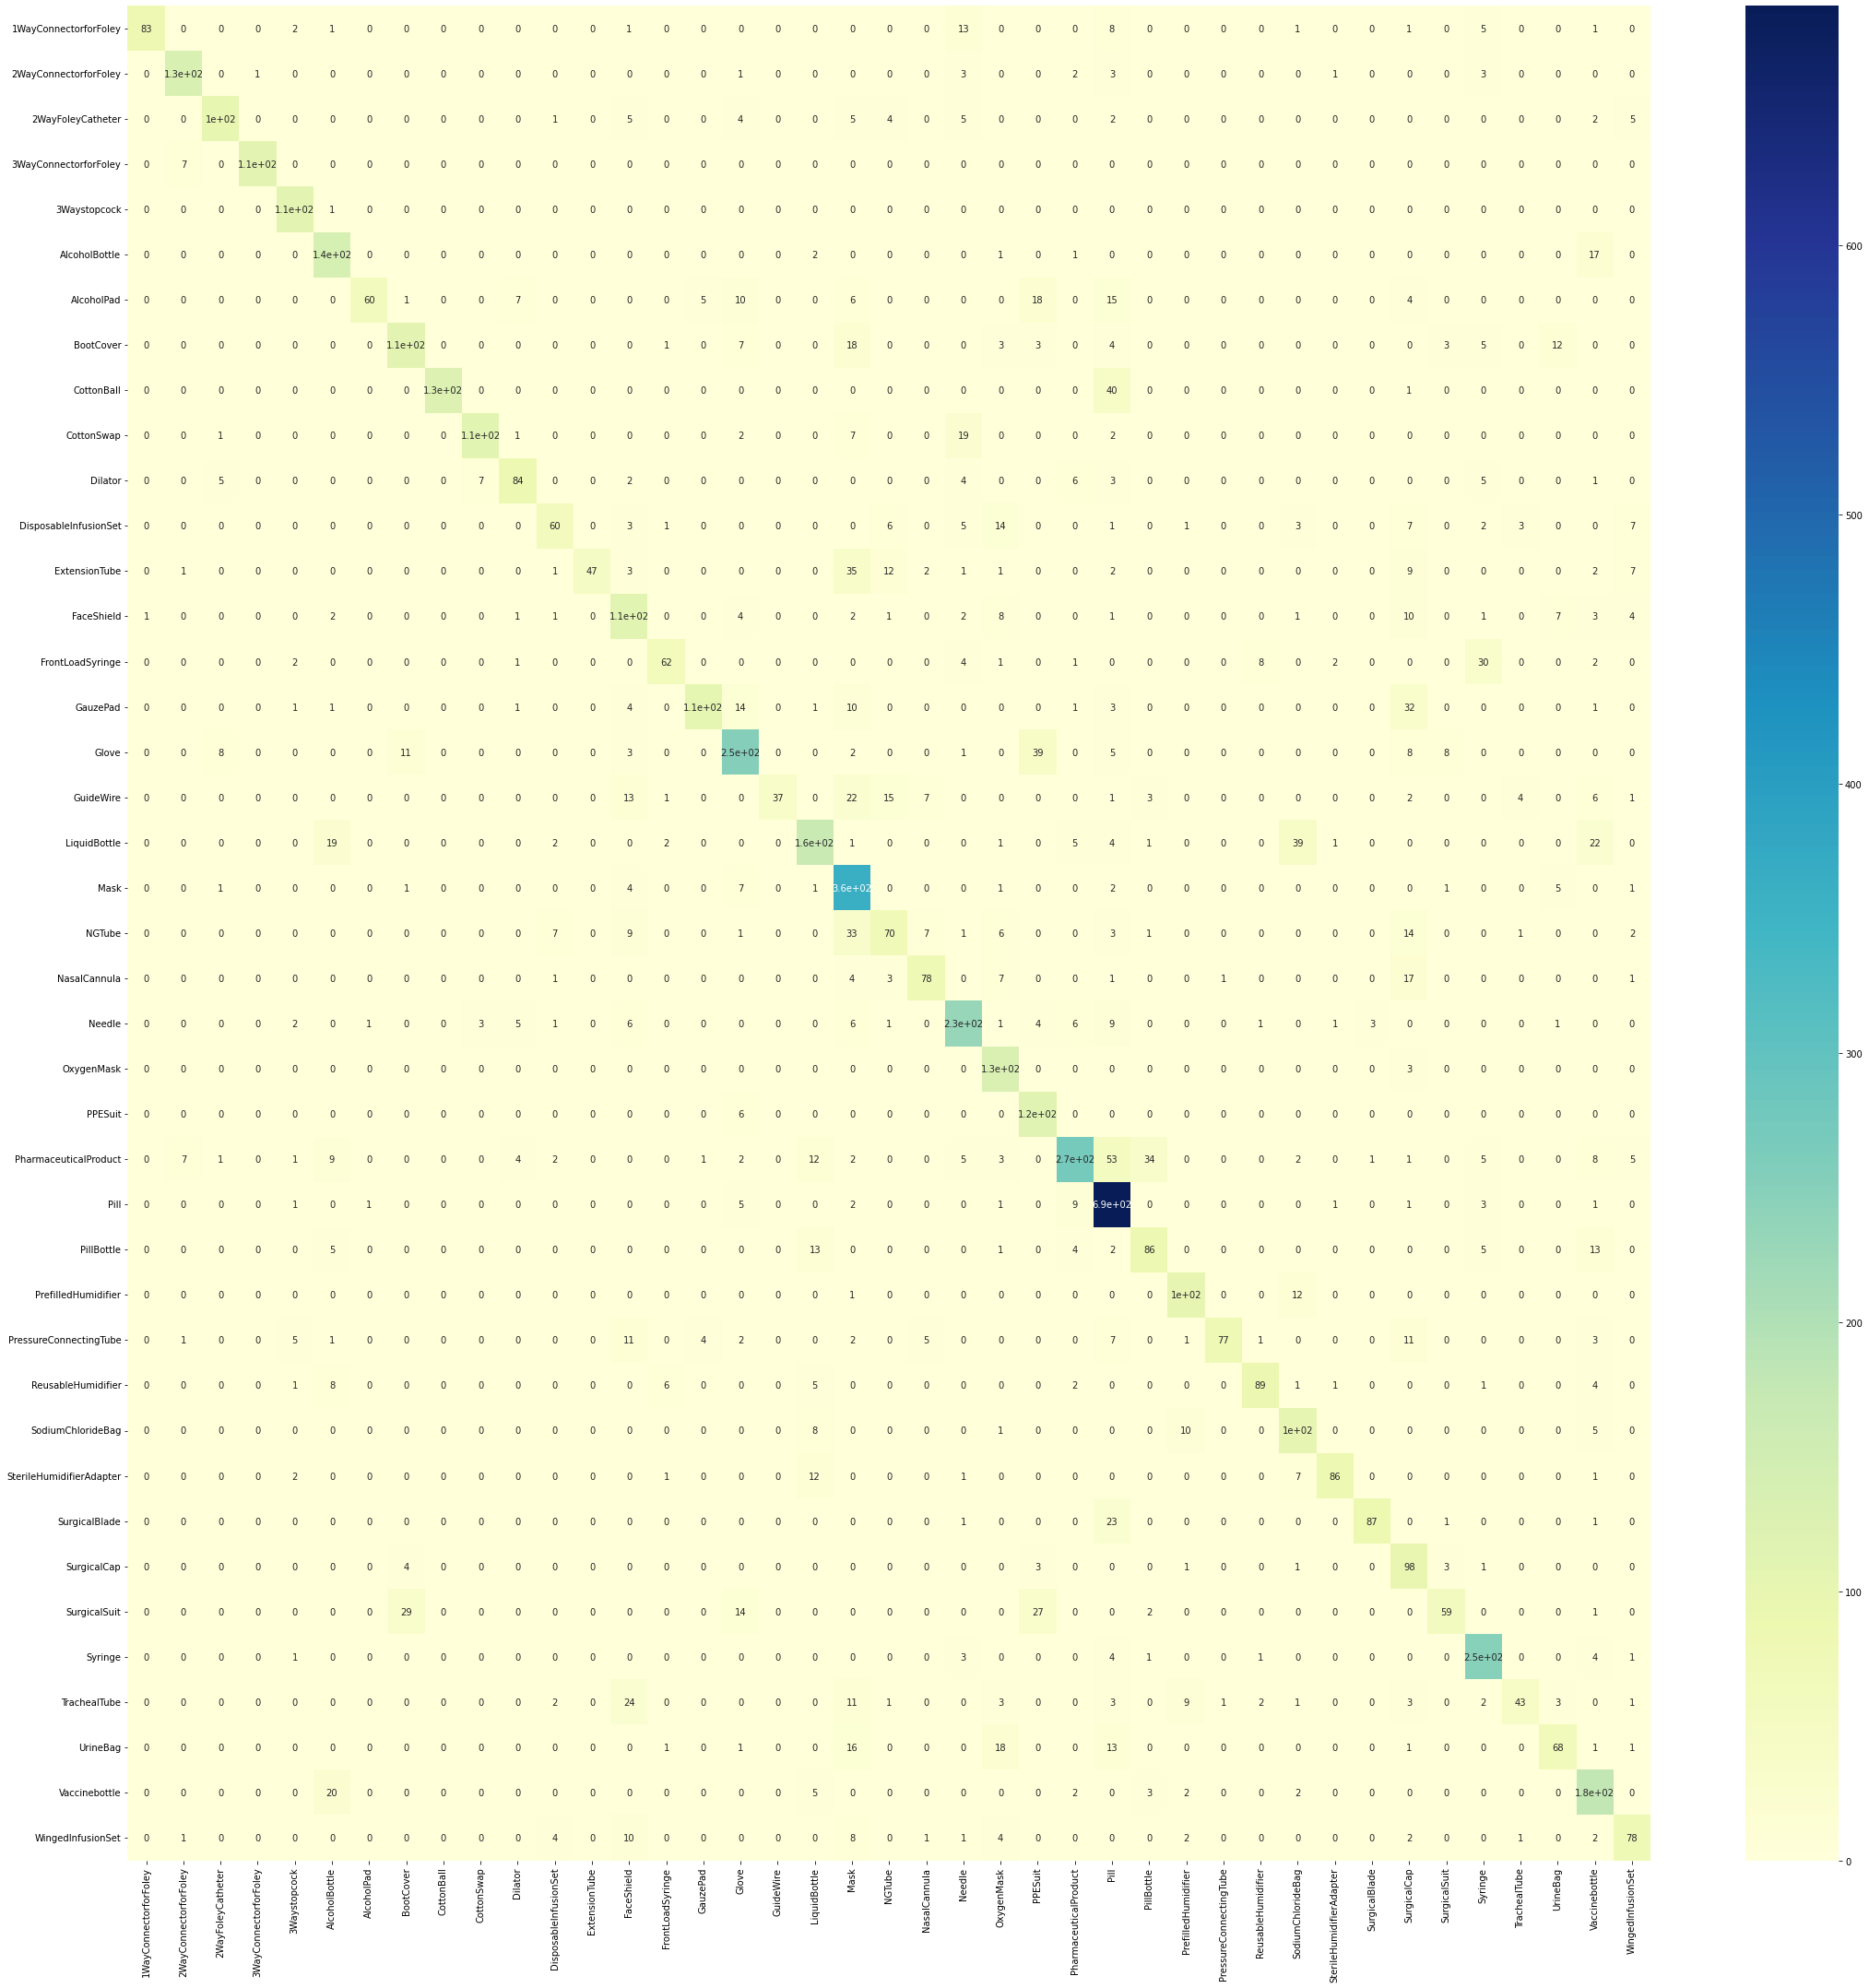

In [8]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMat, index = class_names,
                  columns = class_names)
plt.figure(figsize = (37,37))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")

<AxesSubplot:>

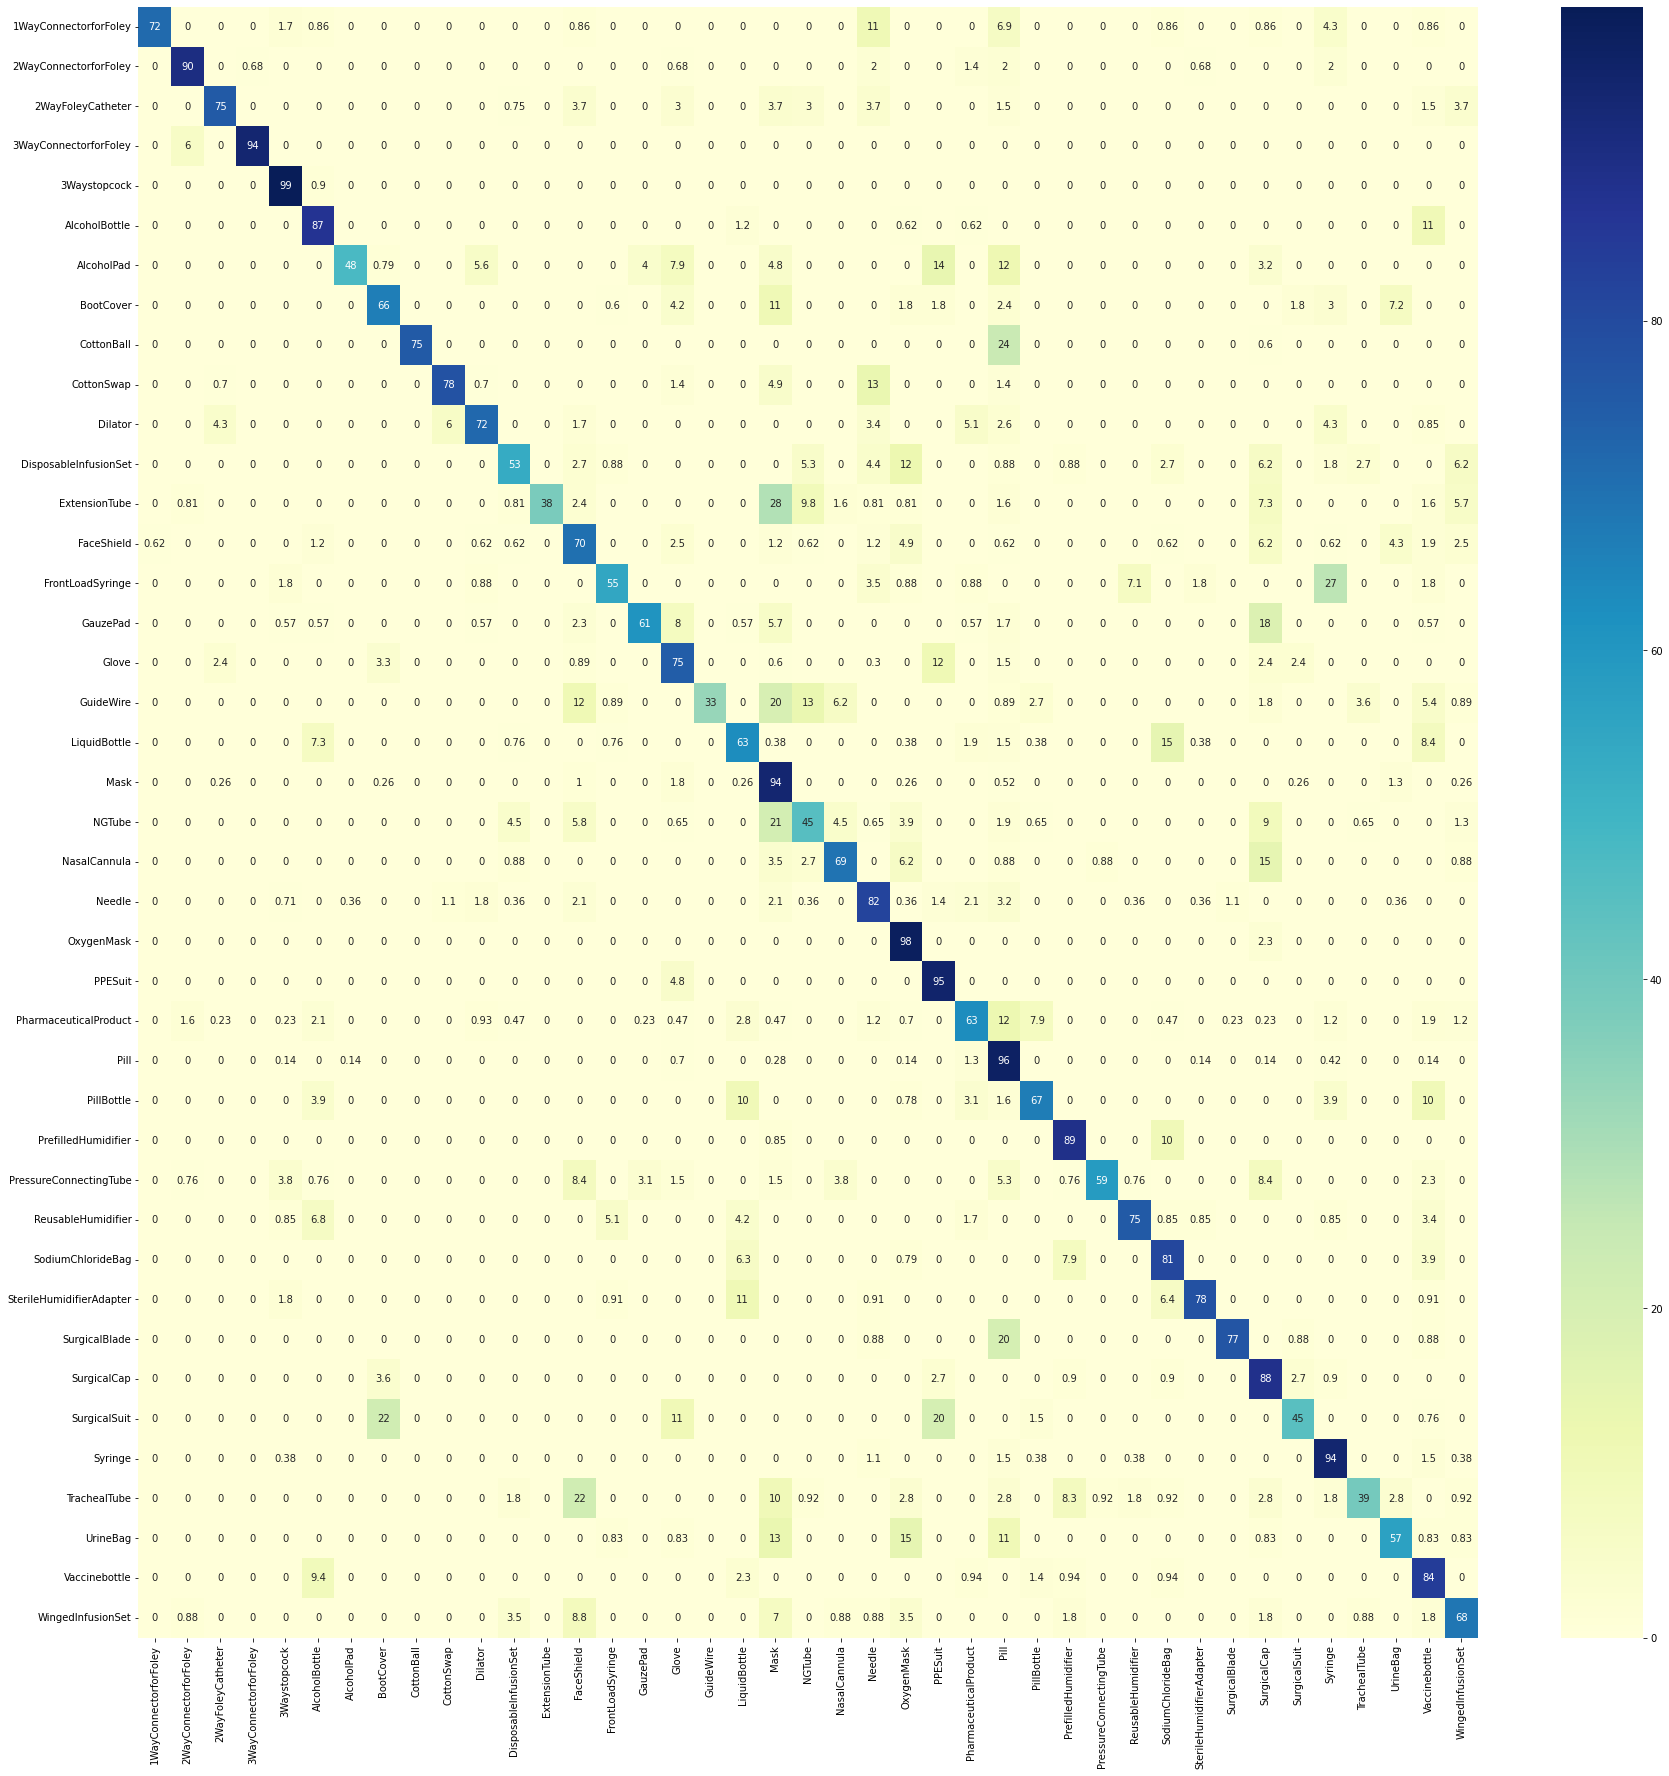

In [11]:
import seaborn as sn
import pandas as pd
df_cm = pd.DataFrame(confusionMatFloatPercent, index = class_names,
                  columns = class_names)
plt.figure(figsize = (30,30))
sn.heatmap(df_cm, annot=True,cmap="YlGnBu")